# HW4 - Breast Cancer Detection using Multiple Instance Learning (MIL) (100 points)

## Course Name: Intelligent Analysis of Biomedical Images

#### Lecturers: Dr. Rohban
#### Name: Mohammad Hossein Sameti
#### Student ID: 401204932

---

**Contact**: Ask your questions in Quera

---




In this part we are going implement the idea proposed by the paper "Breast Cancer Histopathology Image Classification
and Localization using Multiple Instance Learning" and reproduce some of their results. Please read this paper before starting the next part. Here is the link to it:

https://arxiv.org/pdf/2003.00823.pdf

In the next sections, we only use one of the presented datasets in the above paper. In the explanation of every section, it is assumed that you have read the paper before starting that part. It should also be mentioned that you are free to modify everything in this notebook and all provided codes are for better understanding.

You can read the "Attention-based Deep Multiple Instance Learning" paper for more explanation. Here is the link to it:

https://arxiv.org/pdf/1802.04712.pdf

## Imports

Feel free to import any library you need.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, io, models
from torch.utils.data import DataLoader, Dataset, random_split
import warnings
warnings.filterwarnings("ignore")

## Downloading dataset

Here is the code to download and decompress the BreaKHis dataset. This code is written for the google colab environment and you may need to modify it for running on other devices.

Link to the dataset's website:

https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

In [2]:
!wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz -O /content/BreaKHis_v1.tar.gz

--2023-12-25 08:35:08--  http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz [following]
--2023-12-25 08:35:10--  https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4273561758 (4.0G) [application/octet-stream]
Saving to: ‘/content/BreaKHis_v1.tar.gz’

/content/BreaKHis_v 100%[===================>]   3.98G  9.14MB/s    in 7m 49s  

2023-12-25 08:43:01 (8.70 MB/s) - ‘/content/BreaKHis_v1.tar.gz’ saved [4273561758/4273561758]



In [3]:
!tar xzf /content/BreaKHis_v1.tar.gz -C /content

## Data Preparation (35 points)

In this section, you will implement several things:

- A custom pytorch Dataset for our data. You can use the current decompressed folder or change the structure to make it easier to work with.
- Transformations to perform on data (You must first do the patch extraction, then apply the transformations on every patch.)
- Patch extraction code (you can also implement it in the following sections)
- Dataloaders (instead of 80-20 split for train-test sets from the paper, you should use 80-5-15 split for train-val-test sets here and save best model w.r.t. the validation loss)

In [2]:
import os
def getListOfFiles(dirName):
    # create a list of file and sub directories
    # names in the given directory
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

In [3]:
files=getListOfFiles('./BreaKHis_v1/histology_slides/breast')
imgs = {}
for f in files:
    if f.endswith('.png'):
        temp = f.split('/')
        imgs[temp[-3]] = []


In [4]:
for f in files:
    if f.endswith('.png'):
        temp = f.split('/')
        imgs[temp[-3]].append(f)

In [5]:
# Implement the custom dataset here (15 points)
from PIL import Image
class CustomBreaKHis(Dataset):

    def __init__(self, data_dic, magn, transform=None):
        # To-Do
        super(CustomBreaKHis, self).__init__()
        self.transform = transform
        self.magn = magn
        self.path = data_dic
    def __len__(self):
        # To-Do
        return len(self.path[self.magn])
    def __getitem__(self, index):
        # To-Do
        img = self.path[self.magn][index]
        image = [self.transform(Image.open(im)) for im in img]

        temp = img[0].split('/')
        if temp[4] == 'benign':
          return torch.stack(image), torch.tensor([0], dtype=torch.long,requires_grad=False)
        elif temp[4] == 'malignant':
          return torch.stack(image), torch.tensor([1], dtype=torch.long,requires_grad=False)

In [6]:
# Implement the transforms here (5 points)

transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

In [7]:
# Create dataloaders here (5 points)
magnifications = ["40X", "100X", "200X", "400X"]
data = {}
for magn in magnifications:
    data[magn] = {}
    for i, (k, v) in enumerate(imgs.items()):
      data[magn][i] = []
      for j in v:
        if j.split('/')[-2] == magn :
          data[magn][i].append(j)


dataset40x = CustomBreaKHis(data, magn='40X', transform=transform)
dataset100x = CustomBreaKHis(data, magn='100X', transform=transform)
dataset200x = CustomBreaKHis(data, magn='200X', transform=transform)
dataset400x = CustomBreaKHis(data, magn='400X', transform=transform)

dataset40x_train, dataset40x_val, dataset40x_test = random_split(dataset40x, [int(0.7 * len(dataset40x)), int(0.1 * len(dataset40x )), len(dataset40x) - int(0.7 * len(dataset40x)) - int(0.1 * len(dataset40x ))])
dataset100x_train, dataset100x_val, dataset100x_test = random_split(dataset100x, [int(0.7 * len(dataset100x)),  int(0.1 * len(dataset100x )), len(dataset100x) - int(0.7 * len(dataset100x)) - int(0.1 * len(dataset100x ))])
dataset200x_train, dataset200x_val, dataset200x_test = random_split(dataset200x, [int(0.7 * len(dataset200x)),  int(0.1 * len(dataset200x )), len(dataset200x) - int(0.7 * len(dataset200x)) - int(0.1 * len(dataset200x ))])
dataset400x_train, dataset400x_val, dataset400x_test = random_split(dataset400x, [int(0.7 * len(dataset400x)),  int(0.1 * len(dataset400x )), len(dataset400x) - int(0.7 * len(dataset400x)) - int(0.1 * len(dataset400x ))])



# loader40x_train = DataLoader(dataset40x_train, batch_size=None, shuffle=True)
# loader100x_train = DataLoader(dataset100x_train, batch_size=None, shuffle=True)
# loader200x_train = DataLoader(dataset200x_train, batch_size=None, shuffle=True)
# loader400x_train = DataLoader(dataset400x_train, batch_size=None, shuffle=True)


# loader40x_test = DataLoader(dataset40x_test, batch_size=None, shuffle=True)
# loader100x_test = DataLoader(dataset100x_test, batch_size=None, shuffle=True)
# loader200x_test = DataLoader(dataset200x_test, batch_size=None, shuffle=True)
# loader400x_test = DataLoader(dataset400x_test, batch_size=None, shuffle=True)

In [10]:
len(dataset40x_val)

8

In [ ]:
# Implement patch extraction here (10 points)
# If you are going to implement it somewhere else, please comment it here.

## Model Implementation (25 points)

Here, you have to implement the proposed architecture in the paper. The only point is that in the last part of the model, instead of a "dense+softmax" you should implement a "dense+sigmoid".

In [35]:
# Implement the model here (25 points)

class MILModel(nn.Module):
  def __init__(self):
    super(MILModel, self).__init__()
    #self.backbone = models.resnet50(pretrained=False)
    self.Feature_extractor = nn.Sequential(nn.Conv2d(3, 20 , kernel_size=5),
                                            nn.ReLU(),
                                            nn.MaxPool2d(kernel_size=2, stride=2),
                                            nn.Conv2d(20, 50 , kernel_size=5),
                                            nn.ReLU(),
                                            nn.MaxPool2d(kernel_size=2, stride=2),
                                            )

    self.Feature_extractor_fc = nn.Sequential(nn.Linear(16 * 50, 500),
                                             nn.ReLU())


    self.attention = nn.Sequential(nn.Linear(500, 128),
                                     nn.Tanh(),
                                     nn.Linear(128, 1))

    self.classifier = nn.Sequential(nn.Linear(500, 1),
                                    nn.Sigmoid())

  def forward(self, x):
    x = self.Feature_extractor(x)
    x = self.Feature_extractor_fc(x.view(-1, 50 * 4 * 4))
    y = self.attention(x)
    x = F.softmax(torch.transpose(y, 1, 0), dim=1) @ x
    x = self.classifier(x)
    return x


## Training (32 points)

In this section, you will implement the training method and use it to train the model for every magnification. The model has to be trained for at least 60 epochs. But, in every epoch, we use 200 mini-batches to train the model instead of the whole training data, which means with a batch size of one, we use 200 images for training the model in every epoch. With this method, we spend less training time but actually, iterate whole data several times. (You have to make sure that the train loader will get shuffled correctly every epoch)

You should save loss and accuracy per epoch for training and validation sets. Then, you must plot the loss and accuracy of every magnification, which is crucial for scoring this assignment.

Hint: Training the model for one epoch takes around 7 seconds on the Google Colab environment. You have to train every model for at least 60 epochs, but longer training time can result in higher accuracies.

Note: You are not expected to achieve the exact accuracies reported in the paper for getting the full score. A correct implementation and sufficient training epochs receive the total score for this assignment.

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [84]:
# Implement the training method here (20 points)
def train(model, num_epochs, dataloader, dataloader_val, optimizer, criterion, name):
    # To-Do
  Best_accu = 0
  Losses, Accuracy = [], []
  for epoch in range(num_epochs):
      l = 0
      predicted, trues = [], []
      predicted_val, trues_val = [], []
      for bags, labels in dataloader:

          bags, labels = bags.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(bags)
          loss = criterion(outputs[0].type(torch.float32), labels.type(torch.float32))
          loss.backward()
          optimizer.step()
          l += loss
          predicted.append(torch.round(outputs).type(torch.int16).cpu().tolist()[0][0])
          trues.append(labels.cpu().tolist()[0])

      with torch.no_grad():
        for bag, label in dataloader_val:
          bag, label = bag.to(device), label.to(device)
          optimizer.zero_grad()
          output = model(bag)
          #print(torch.round(output[0]).cpu().tolist(), label.cpu().tolist())
          predicted_val.append(torch.round(output).cpu().tolist()[0][0])
          trues_val.append(label.cpu().tolist()[0])

      acc_val = accuracy_score(predicted_val, trues_val)
      if acc_val > Best_accu:
        torch.save(model.state_dict(), f'/content/{name}.pt')
      scheduler.step(acc_val)
      l /= len(dataloader)
      acc = accuracy_score(predicted, trues)
      Losses.append(l.cpu().detach().item())
      Accuracy.append(acc)
      print(f'Epoch {epoch + 1}, Loss: {l.item():.3f}, Accuracy: {acc:.3f}, Acuracy_val: {acc_val:.3f}')
  return Losses, Accuracy

In [85]:
model40x = MILModel()
model40x = model40x.to(device)
criterion=nn.BCELoss()
optim=torch.optim.Adam(model40x.parameters(),lr=5e-4, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')

In [87]:
# Train the model on the 40X data here (1 points)
epochs = 10
magn = "40X"
Loss, accu = train(model40x, epochs, dataset40x_train, dataset40x_val, optim, criterion, 'model40x')

Epoch 1, Loss: 0.542, Accuracy: 0.719, Acuracy_val: 0.750
Epoch 2, Loss: 0.550, Accuracy: 0.684, Acuracy_val: 0.750
Epoch 3, Loss: 0.519, Accuracy: 0.807, Acuracy_val: 0.750
Epoch 4, Loss: 0.539, Accuracy: 0.772, Acuracy_val: 0.750
Epoch 5, Loss: 0.528, Accuracy: 0.719, Acuracy_val: 0.750
Epoch 6, Loss: 0.526, Accuracy: 0.772, Acuracy_val: 0.750
Epoch 7, Loss: 0.526, Accuracy: 0.807, Acuracy_val: 0.750
Epoch 8, Loss: 0.468, Accuracy: 0.789, Acuracy_val: 1.000
Epoch 9, Loss: 0.459, Accuracy: 0.807, Acuracy_val: 1.000
Epoch 10, Loss: 0.444, Accuracy: 0.842, Acuracy_val: 1.000


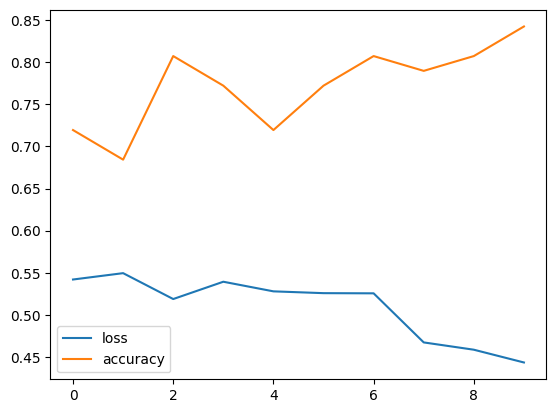

In [88]:
# Plot loss and accuracy per epoch for 40X here (2 points)
import matplotlib.pyplot as plt

plt.plot(Loss, label='loss')
plt.plot(accu, label='accuracy')
plt.legend()
plt.show()

In [89]:
torch.cuda.empty_cache()

In [90]:
model100x = MILModel()
model100x = model100x.to(device)
criterion=nn.BCELoss()
optim100=torch.optim.Adam(model100x.parameters(),lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim100, 'min')

In [91]:
# Train the model on the 100X data here (1 points)
epochs = 10
magn = "100X"
Loss, accu = train(model100x, epochs, dataset100x_train, dataset100x_val, optim100, criterion, 'model100x')

Epoch 1, Loss: 0.684, Accuracy: 0.596, Acuracy_val: 0.875
Epoch 2, Loss: 0.651, Accuracy: 0.702, Acuracy_val: 0.875
Epoch 3, Loss: 0.640, Accuracy: 0.702, Acuracy_val: 0.875
Epoch 4, Loss: 0.636, Accuracy: 0.702, Acuracy_val: 0.875
Epoch 6, Loss: 0.627, Accuracy: 0.702, Acuracy_val: 0.875
Epoch 7, Loss: 0.624, Accuracy: 0.702, Acuracy_val: 0.875
Epoch 8, Loss: 0.622, Accuracy: 0.702, Acuracy_val: 0.875
Epoch 9, Loss: 0.619, Accuracy: 0.702, Acuracy_val: 0.875
Epoch 10, Loss: 0.616, Accuracy: 0.702, Acuracy_val: 0.875


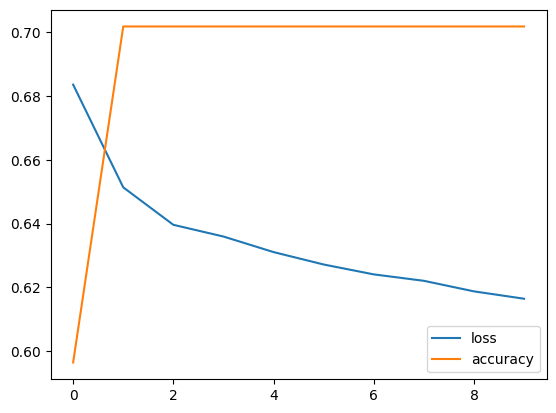

In [92]:
# Plot loss and accuracy per epoch for 100X here (2 points)
import matplotlib.pyplot as plt

plt.plot(Loss, label='loss')
plt.plot(accu, label='accuracy')
plt.legend()
plt.show()

In [93]:
model200x = MILModel()
model200x = model200x.to(device)
criterion=nn.BCELoss()
optim200x=torch.optim.Adam(model200x.parameters(),lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim200x, 'min')

In [94]:
# Train the model on the 200X data here (1 points)
epochs = 10
magn = "200X"
Loss, accu = train(model200x, epochs, dataset200x_train, dataset200x_val, optim200x, criterion, 'model200x')

Epoch 1, Loss: 0.663, Accuracy: 0.632, Acuracy_val: 0.625
Epoch 2, Loss: 0.635, Accuracy: 0.684, Acuracy_val: 0.625
Epoch 3, Loss: 0.636, Accuracy: 0.684, Acuracy_val: 0.625
Epoch 4, Loss: 0.619, Accuracy: 0.684, Acuracy_val: 0.625
Epoch 5, Loss: 0.602, Accuracy: 0.684, Acuracy_val: 0.625
Epoch 6, Loss: 0.564, Accuracy: 0.719, Acuracy_val: 0.625
Epoch 7, Loss: 0.526, Accuracy: 0.772, Acuracy_val: 0.625
Epoch 8, Loss: 0.488, Accuracy: 0.789, Acuracy_val: 0.625
Epoch 9, Loss: 0.625, Accuracy: 0.737, Acuracy_val: 0.625
Epoch 10, Loss: 0.553, Accuracy: 0.754, Acuracy_val: 0.625


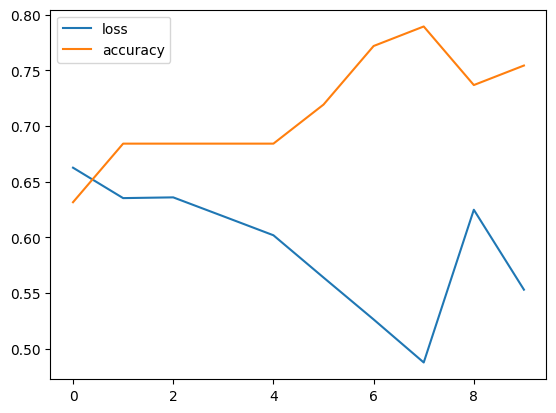

In [95]:
# Plot loss and accuracy per epoch for 200X here (2 points)
plt.plot(Loss, label='loss')
plt.plot(accu, label='accuracy')
plt.legend()
plt.show()

In [103]:
model400x = MILModel()
model400x = model400x.to(device)
criterion=nn.BCELoss()
optim400x=torch.optim.Adam(model400x.parameters(),lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim400x, 'min')

In [104]:
# Train the model on the 400X data here (1 points)
epochs = 10
magn = "400X"
Loss, accu = train(model400x, epochs, dataset400x_train, dataset400x_val, optim400x, criterion, 'model400x')

Epoch 1, Loss: 0.648, Accuracy: 0.684, Acuracy_val: 1.000
Epoch 2, Loss: 0.594, Accuracy: 0.684, Acuracy_val: 1.000
Epoch 3, Loss: 0.551, Accuracy: 0.684, Acuracy_val: 1.000
Epoch 4, Loss: 0.520, Accuracy: 0.719, Acuracy_val: 0.750
Epoch 5, Loss: 0.497, Accuracy: 0.737, Acuracy_val: 0.500
Epoch 6, Loss: 0.481, Accuracy: 0.772, Acuracy_val: 0.500
Epoch 7, Loss: 0.468, Accuracy: 0.807, Acuracy_val: 0.500
Epoch 8, Loss: 0.462, Accuracy: 0.772, Acuracy_val: 0.500
Epoch 9, Loss: 0.449, Accuracy: 0.825, Acuracy_val: 0.500
Epoch 10, Loss: 0.444, Accuracy: 0.825, Acuracy_val: 0.625


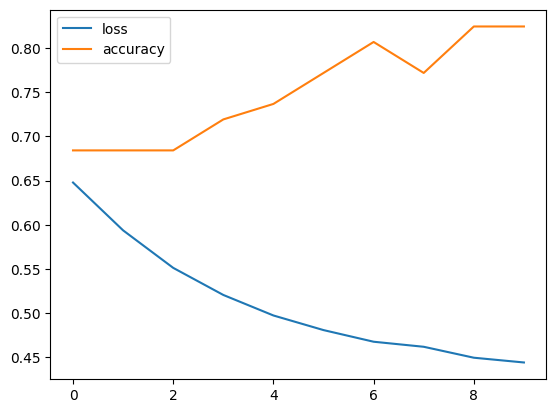

In [105]:
# Plot loss and accuracy per epoch for 400X here (2 points)
plt.plot(Loss, label='loss')
plt.plot(accu, label='accuracy')
plt.legend()
plt.show()

## Evaluation (8 points)

Now, we need to evaluate our best model in every magnification on the test set. Complete the test method and use it for the evaluation of models.

In [110]:
# Implement the test method here (4 points)
def test(model, dataloader_val):
  predicted_val, trues_val = [], []
  with torch.no_grad():
    for bag, label in dataloader_val:
      bag, label = bag.to(device), label.to(device)
      output = model(bag)
      #print(torch.round(output[0]).cpu().tolist(), label.cpu().tolist())
      predicted_val.append(torch.round(output).cpu().tolist()[0][0])
      trues_val.append(label.cpu().tolist()[0])

  acc_val = accuracy_score(predicted_val, trues_val)

  return acc_val
    # To-Do

In [112]:
# Test the model trained on the 40X data here (1 points)
magn = "40X"
model = MILModel()
model.load_state_dict(torch.load('/content/model40x.pt'))
model = model.to(device)
test(model, dataset40x_test)

0.7058823529411765

In [113]:
# Test the model trained on the 100X data here (1 points)
magn = "100X"
model = MILModel()
model.load_state_dict(torch.load('/content/model100x.pt'))
model = model.to(device)
test(model, dataset100x_test)

0.6470588235294118

In [114]:
# Test the model trained on the 200X data here (1 points)
magn = "200X"
model = MILModel()
model.load_state_dict(torch.load('/content/model200x.pt'))
model = model.to(device)
test(model, dataset200x_test)

0.8235294117647058

In [116]:
# Test the model trained on the 400X data here (1 points)
magn = "400X"
model = MILModel()
model.load_state_dict(torch.load('/content/model400x.pt'))
model = model.to(device)
test(model, dataset400x_test)

0.7647058823529411